## Implementação

In [2]:
import numpy as np
import pandas as pd

Parte-se do pressuposto que os dados estão organizados da seguinte maneira, numa matriz $R$

User_ID | Item_1 | $\dots$ | Item_n , e cada célula contém a avaliação do usuário User_m para o item da coluna específica, caso o usuário não tenha avaliado o item, colocamos um valor default de 0.

O primeiro passo seria pegar esses dados e dividí-los nas matrizes $M_1$ e $M_2$, uma que diz respeito aos usuários e outra que diz respeito aos usuários e suas caracteristicas e a outra diz respeito aos itens e suas características.

As duas matrizes são iniciadas com valores aleatórios.

Após inicializar essas duas matrizes, é preciso criar a matriz $\hat{R}$, que terá uma configuração do tipo, 

User_ID | Item_1 | Item_2 | $\dots$ | Item_n

E cada célula será preenchida com um valor de "Rating", que por sua vez será resultado da seguinte multiplicação, 

$$ \hat{R} = M_1 \times M_2^T $$

Ok, temos uma matriz $\hat{R}$, formada pela multiplicação de valores aleatórios, e portanto, tem vários valores aleatórios. A questão é:

Como isso será útil para sistemas de recomendação? 

Realmente inicialmente não teremos resultados satisfatórios tendo em vista que só tivemos a utilização de valores aleatórios. Porém, para melhorarmos isso, utilizaremos algoritmos de otimização como o SGD, para que os valores das matrizes $M_1$ e $M_2$ sejam ajustados e fiquem mais condizentes com os valores da matriz de avaliações $R$.

Ao final desse processo teremos uma matriz de recomendação $\hat{R}$, com valores condizentes com a realidade dos dados. Abaixo temos a classe MatrixFactorization completa.

In [47]:
class MatrixFactorization():
    def __init__(self, number_caracteristics, max_rating=5, min_rating=1, learning_rate=0.01, max_iter=500, regularization=0.01, momentum=0.9):
        
        self.number_caracteristics = number_caracteristics # tamanho de cada embedding 
        self.max_rating = max_rating 
        self.min_rating = min_rating
        self.learning_rate = learning_rate # learning rate do sgd
        self.max_iter = max_iter 
        self.regularization = regularization #fator de regularização 
        self.momentum = momentum  # inicialmente eu não tinha colocado o termo de momentum 

    def criar_matrizes(self, Matriz_R):
        # cria as matrizes de usuário e item que vao ser usadas para a criacao da matriz r_hat
        #self.user_matrix = np.random.normal(loc=0, scale=1/self.number_caracteristics, size=(Matriz_R.shape[0], self.number_caracteristics))
        #self.item_matrix = np.random.normal(loc=0, scale=1/self.number_caracteristics, size=(Matriz_R.shape[1], self.number_caracteristics))
        self.user_matrix = np.random.random(size=(Matriz_R.shape[0], self.number_caracteristics))
        self.item_matrix = np.random.random(size=(Matriz_R.shape[1], self.number_caracteristics))
        
    def criar_matriz_R_hat(self):
        self.r_hat = np.dot(self.user_matrix, self.item_matrix.T)
    
    def calcular_erro(self, Matriz_R):
        erro = (Matriz_R - (self.user_matrix @ self.item_matrix.T)) 
        mse = np.mean(erro ** 2)
        return np.sqrt(mse)

# o erro deve ta no calculo e mudança do gradiente, que eh daq p baixo
# tentar fazer sem usar a matriz esparsa 

    def calcular_gradientes(self, Matriz_R):

        # aqui é a ideia de criar uma máscara para os valores que não foram avaliados pelos usuários
        # retirado do github https://github.com/wangyuhsin/matrix-factorization/blob/main/README.md   
        array_r = np.array(Matriz_R)
        mask = np.where(array_r != 0, 1, 0)
        n = mask.sum() # n aqui eh o numero de avaliacoes (?)


        #pred_user = np.dot(self.user_matrix, self.item_matrix.T) * mask
        #pred_item = np.dot(self.item_matrix, self.user_matrix.T) * mask
        pred_user = (self.user_matrix @ self.item_matrix.T) * mask
        pred_item = (self.item_matrix @ self.user_matrix.T).T * mask

        grad_user = -2 /n * np.dot ((array_r - pred_user), self.item_matrix)
        grad_itens = -2/n * np.dot((array_r - pred_item).T, self.user_matrix)
        return grad_user, grad_itens
    

    def treinar(self, Matriz_R, mostrar_erro=False):
        array_R = np.array(Matriz_R)        

        self.erros_iteracoes = []
 
        v_user = np.zeros_like(self.user_matrix)
        v_items = np.zeros_like(self.item_matrix)

        for iter in range(self.max_iter):
            
            user_grad, items_grad = self.calcular_gradientes(Matriz_R)

            v_user = self.momentum * v_user + 0.1 * user_grad 
            v_items = self.momentum * v_items + 0.1 * items_grad
            # nn deixa claro no codigo mas eu imagino que o 0.1 seja o fator de regularizacao

            self.user_matrix -= self.learning_rate * v_user
            self.item_matrix -= self.learning_rate * v_items

            if mostrar_erro:
                    if iter %10 == 0:
                        erro_atual = self.calcular_erro(array_R)
                        print(f"Iteração: {iter + 1}, Erro: {erro_atual}") 
                        self.erros_iteracoes.append(erro_atual)
      
        
        self.r_hat = np.clip(np.dot(self.user_matrix, self.item_matrix.T), self.min_rating, self.max_rating)
        return self.r_hat

    def fit(self, Matriz_R, mostrar_erro=False):
        self.criar_matrizes(Matriz_R)
        self.criar_matriz_R_hat()  
        return self.treinar(Matriz_R, mostrar_erro)


## Testes

Como dito no início, aqui se pressupõe que os valores estão organizados de determinada maneira, para isso peguei o dataset do Movielens100k pivoteado.

Caso seja de interesse do leitor, a limpeza do dataset está disponível em 

https://github.com/Lucasaraga0/k_means_recommendation-system/blob/main/notebooks_and_functions/datasets_cleaning.ipynb

Desse mesmo repositório utilizarei o dataset Movie_pivot_1.csv. 

In [32]:
Matriz_R = pd.read_csv("movies_pivot_1.csv")
Matriz_R.fillna(0,inplace= True)
Matriz_R.drop(columns= ['User Average Rating'], inplace= True)
Matriz_R

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998).1,You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
MatrizF = MatrixFactorization(number_caracteristics= 100, max_iter= 3000, regularization= 0.001, learning_rate= 0.5, momentum= 0.9 )
MatrizF.fit(Matriz_R= Matriz_R,mostrar_erro= True)

Iteração: 1, Erro: 24.803651290058593
Iteração: 11, Erro: 21.46123743522802
Iteração: 21, Erro: 18.192859073405277
Iteração: 31, Erro: 16.308874031582345
Iteração: 41, Erro: 15.226865522731893
Iteração: 51, Erro: 14.544928350282769
Iteração: 61, Erro: 14.06827498453523
Iteração: 71, Erro: 13.703229578299382
Iteração: 81, Erro: 13.403814542996255
Iteração: 91, Erro: 13.146795155861941
Iteração: 101, Erro: 12.919861724834005
Iteração: 111, Erro: 12.715939605549025
Iteração: 121, Erro: 12.530536906949061
Iteração: 131, Erro: 12.360531938837509
Iteração: 141, Erro: 12.20359899848103
Iteração: 151, Erro: 12.057921322030765
Iteração: 161, Erro: 11.922036895797872
Iteração: 171, Erro: 11.794746745335285
Iteração: 181, Erro: 11.675054382432473
Iteração: 191, Erro: 11.562122607927677
Iteração: 201, Erro: 11.455241350398744
Iteração: 211, Erro: 11.353803266849669
Iteração: 221, Erro: 11.25728501866457
Iteração: 231, Erro: 11.16523271062781
Iteração: 241, Erro: 11.077250392440002
Iteração: 251, E

array([[4.31622974, 3.29225328, 3.98150039, ..., 5.        , 5.        ,
        5.        ],
       [4.40985458, 4.82556088, 3.67534691, ..., 5.        , 5.        ,
        5.        ],
       [2.93784185, 4.85116597, 2.81036545, ..., 5.        , 5.        ,
        5.        ],
       ...,
       [4.89042514, 5.        , 4.59808395, ..., 5.        , 5.        ,
        5.        ],
       [5.        , 4.97046604, 4.35743448, ..., 5.        , 5.        ,
        5.        ],
       [3.12109409, 3.4115352 , 3.36147406, ..., 4.00439789, 5.        ,
        5.        ]])

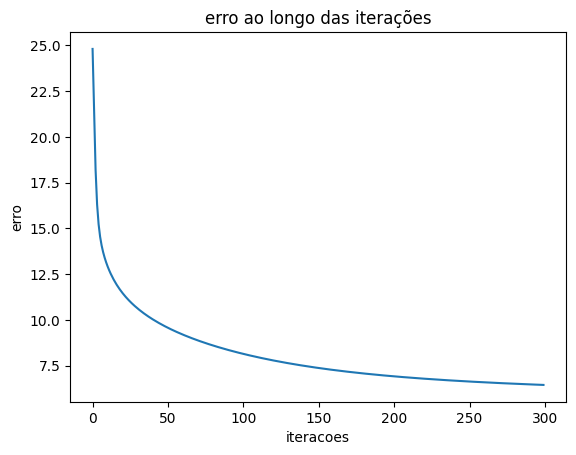

In [51]:
erros = MatrizF.erros_iteracoes
import matplotlib.pyplot as plt

plt.plot(erros)
plt.xlabel("iteracoes")
plt.ylabel("erro")
plt.title("erro ao longo das iterações")
plt.show()

In [52]:
MatrizF.r_hat
teste = pd.DataFrame(MatrizF.r_hat, columns= Matriz_R.columns)

In [53]:
teste

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998).1,You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,4.316230,3.292253,3.981500,3.370677,3.013696,3.057277,3.665320,3.615960,4.164425,3.080273,...,5.000000,5.000000,4.607874,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
1,4.409855,4.825561,3.675347,4.205869,5.000000,5.000000,2.879652,4.622238,4.157554,3.758474,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
2,2.937842,4.851166,2.810365,3.937041,5.000000,5.000000,4.241038,3.917998,4.056922,4.054425,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
3,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.455256,4.759963,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
4,3.903631,2.326907,3.408629,3.897184,1.311445,3.079433,3.178284,3.181071,4.178253,3.174913,...,3.084465,4.749009,5.000000,4.122794,5.0,4.293707,4.782381,5.000000,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,5.000000,5.000000,5.000000,4.177810,4.364937,5.000000,4.703566,5.000000,4.214416,3.972672,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
939,3.274138,2.995910,4.011680,2.431385,4.671072,4.881198,3.309427,4.875565,3.237593,3.443368,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
940,4.890425,5.000000,4.598084,5.000000,5.000000,5.000000,4.259197,5.000000,4.973227,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
941,5.000000,4.970466,4.357434,4.698500,4.760708,4.484693,3.414074,4.037560,3.865651,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0


In [ ]:
erros

[]

In [54]:
matriz_final = MatrizF.r_hat 
np.save("matriz_r_hat",matriz_final)
np.save("matriz_m1", MatrizF.user_matrix)
np.save("matriz_m2", MatrizF.item_matrix)

In [ ]:
matriz_final[0]
data_final = pd.DataFrame(matriz_final, columns= Matriz_R.columns)
data_final.to_csv("matriz_final_com_recomendacoes.csv")